<a href="https://colab.research.google.com/github/vivekbiju/Explainable-AI-For-Skin-Cancer-Detection/blob/main/ResNet50_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python
!pip install kagglehub
!pip install tensorflow
!pip install shap
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 128.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 166.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 163.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import random
import cv2
import kagglehub

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

import shap
from tqdm import tqdm

warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Attempting to download dataset...


100%|██████████| 79.4M/79.4M [00:00<00:00, 108MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhaveshmittal/melanoma-cancer-dataset/versions/1
Number of images benign: 7289
Number of images malignant: 6590


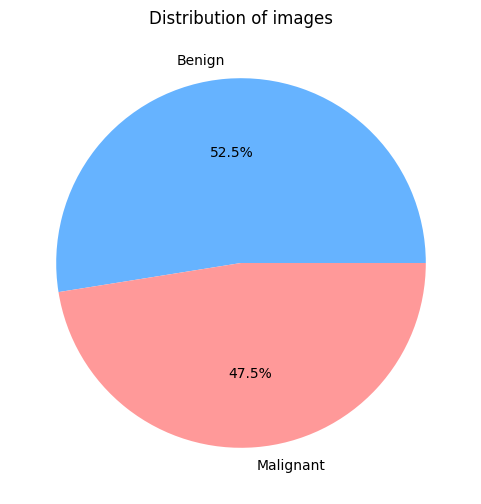

In [3]:
# Consistent random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Setting image dimensions as constants
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Helper function for consistent image loading and preprocessing
def load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Loads, resizes, converts to RGB, and preprocesses a single image for model input.
    Args:
        img_path (str): Path to the image file.
        target_size (tuple): Desired (height, width) for resizing.
    Returns:
        tuple: (preprocessed_image_array (batch of 1), original_rgb_resized_image, original_full_size_image)
               Returns (None, None, None) if image cannot be loaded.
    """
    img_full_size = cv2.imread(img_path)
    if img_full_size is None:
        return None, None, None

    img_resized = cv2.resize(img_full_size, target_size)
    img_rgb_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_array_preprocessed = preprocess_input(np.expand_dims(img_rgb_resized, axis=0)) # Model input expects batch dim
    return img_array_preprocessed, img_rgb_resized, cv2.cvtColor(img_full_size, cv2.COLOR_BGR2RGB) # Return original RGB for display


# Dataset loading
print("Attempting to download dataset...")
try:
    path = kagglehub.dataset_download("bhaveshmittal/melanoma-cancer-dataset")
    print("Path to dataset files:", path)
except Exception as e:
    print(f"Error downloading dataset from Kaggle Hub: {e}")
    print("Please ensure kagglehub is installed and configured correctly.")
    exit_script = input("Dataset download failed. Do you want to exit the script? (y/n): ")
    if exit_script.lower() == 'y':
        exit()
    else:
        print("Proceeding without dataset. This will likely cause errors later.")
        path = "."

train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

# Checking if paths exist after download
if not os.path.exists(train_path) or not os.path.exists(test_path):
    print(f"Error: Training or test path not found. Please ensure the dataset is downloaded correctly to '{path}'.")
    exit()

# images count
ben = len(os.listdir(os.path.join(train_path, "Benign"))) + len(os.listdir(os.path.join(test_path, "Benign")))
mal = len(os.listdir(os.path.join(train_path, "Malignant"))) + len(os.listdir(os.path.join(test_path, "Malignant")))

print(f"Number of images benign: {ben}")
print(f"Number of images malignant: {mal}")

# Pie chart for class distribution
plt.figure(figsize=(6,6))
plt.pie([ben, mal], labels=['Benign', 'Malignant'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title("Distribution of images")
plt.show()



 sample Benign images


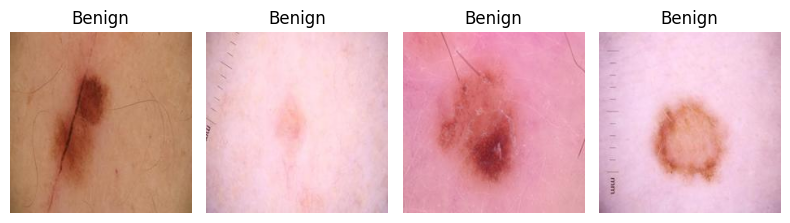


 sample Malignant images


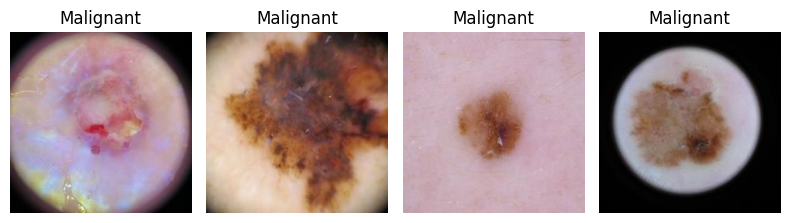

In [4]:
# sample images from dataset
print("\n sample Benign images")
plt.figure(figsize=(8, 5))
benign_sample_images = [f for f in os.listdir(os.path.join(train_path, 'Benign')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for i, img_name in enumerate(benign_sample_images[:4]):
    img_path = os.path.join(train_path, 'Benign', img_name)
    _, img_rgb_display, _ = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    if img_rgb_display is not None:
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_rgb_display)
        plt.title("Benign")
        plt.axis('off')
plt.tight_layout()
plt.show()

print("\n sample Malignant images")
plt.figure(figsize=(8, 5))
malignant_sample_images = [f for f in os.listdir(os.path.join(train_path, 'Malignant')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for i, img_name in enumerate(malignant_sample_images[:4]):
    img_path = os.path.join(train_path, 'Malignant', img_name)
    _, img_rgb_display, _ = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    if img_rgb_display is not None:
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_rgb_display)
        plt.title("Malignant")
        plt.axis('off')
plt.tight_layout()
plt.show()


In [6]:
#  Data Generators
print("\nSetting up data generators...")
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    shuffle=True,
    subset="training",
    class_mode='categorical',
    batch_size=32,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset="validation",
    class_mode='categorical',
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)
# Building model with ResNet50 base
print("\nBuilding ResNet50-based model")
resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
resnet.trainable = False

model = tf.keras.Sequential([
    resnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=l2(0.01)) # 2 classes: Benign, Malignant
])

model.summary()
# Optimizer and Callbacks
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=8,
    min_lr=1e-7,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8, # Increased patience for better convergence
    restore_best_weights=True,
    verbose=1
)

callbacks = [reduce_lr, early_stopping]


Setting up data generators...
Found 9504 images belonging to 2 classes.
Found 2375 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

Building ResNet50-based model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,620,530 (90.11 MB)

 Trainable params: 32,818 (128.20 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
# Training the model
print("\nStarting initial model training (feature extraction)")
start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks
)
end_time = time.time()
total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"\nTotal initial training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

# Fine-tuning
print("\nStarting fine-tuning of the model")
resnet.trainable = True
# Freeze early layers to retain low-level features
for layer in resnet.layers[:100]:
    layer.trainable = False

optimizer_finetune = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer_finetune, loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=callbacks
)

# Save the trained model
model_save_path = "melanoma_detection_model.h5"
try:
    model.save(model_save_path)
    print(f"\nModel saved successfully at: {model_save_path}")
except Exception as e:
    print(f"Error saving model: {e}")


Starting initial model training (feature extraction)
Epoch 1/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 104s 338ms/step - accuracy: 0.7032 - loss: 0.9542 - val_accuracy: 0.7773 - val_loss: 0.7435 - learning_rate: 1.0000e-04
Epoch 2/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 99s 334ms/step - accuracy: 0.8429 - loss: 0.6364 - val_accuracy: 0.7941 - val_loss: 0.6850 - learning_rate: 1.0000e-04
Epoch 3/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 97s 328ms/step - accuracy: 0.8635 - loss: 0.5602 - val_accuracy: 0.7966 - val_loss: 0.6326 - learning_rate: 1.0000e-04
Epoch 4/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 98s 331ms/step - accuracy: 0.8752 - loss: 0.5139 - val_accuracy: 0.8025 - val_loss: 0.6150 - learning_rate: 1.0000e-04
Epoch 5/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 99s 334ms/step - accuracy: 0.8812 - loss: 0.4827 - val_accuracy: 0.8055 - val_loss: 0.5773 - learning_rate: 1.0000e-04
Epoch 6/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 99s 332ms/step - accuracy: 0.8821 - loss: 0.4639 - val_accuracy: 0.8076 - val_loss: 0.5820 - learning_rate: 1.


Model saved successfully at: melanoma_detection_model.h5


In [10]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Make predictions on the test set
test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_true = test_generator.classes

print("Predictions and true labels obtained.")

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step
Predictions and true labels obtained.


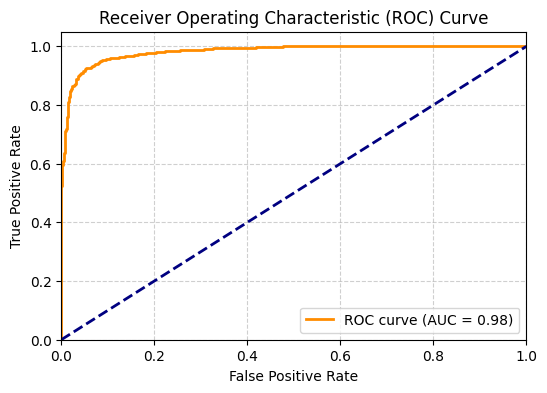

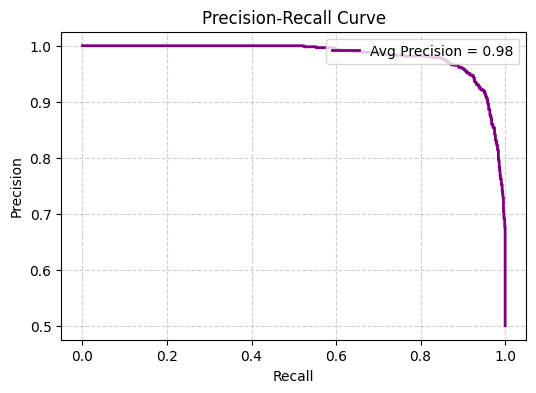

In [11]:
# ROC Curve
if y_pred_probs.shape[1] == 2:
    y_true_categorical = to_categorical(y_true, num_classes=2)
    fpr, tpr, thresholds = roc_curve(y_true_categorical[:,1], y_pred_probs[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_true_categorical[:,1], y_pred_probs[:,1])
average_precision = average_precision_score(y_true_categorical[:,1], y_pred_probs[:,1])

plt.figure(figsize=(6,4))
plt.plot(recall, precision, color='purple', lw=2, label=f'Avg Precision = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



Visualizing sample predictions from the test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step


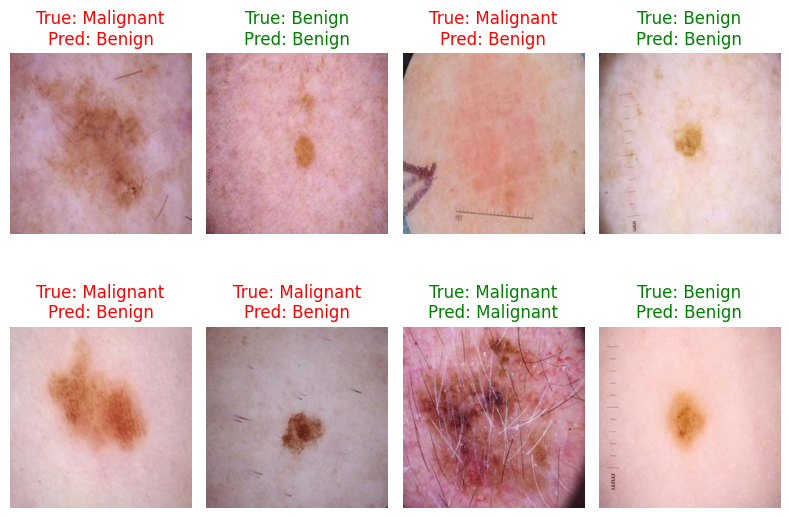

In [12]:
# Prediction and Visualisation
def visualise_predictions(model, generator, class_names, num_images=8):
    """
    Visualises predictions for a few images from a generator, prioritizing misclassified.
    Args:
        model: Trained Keras model.
        generator: Keras ImageDataGenerator.
        class_names (list): List of class names.
        num_images (int): Number of images to visualise.
    """
    generator.reset() # Ensure fresh start
    true_labels_arr = generator.classes
    pred_labels_arr = np.argmax(model.predict(generator), axis=1)

    correct_indices = np.where(true_labels_arr == pred_labels_arr)[0]
    incorrect_indices = np.where(true_labels_arr != pred_labels_arr)[0]

    selected_indices = []
    # Prioritize misclassified samples
    num_incorrect_to_pick = min(num_images // 2, len(incorrect_indices))
    num_correct_to_pick = min(num_images - num_incorrect_to_pick, len(correct_indices))

    selected_indices.extend(random.sample(list(incorrect_indices), num_incorrect_to_pick))
    selected_indices.extend(random.sample(list(correct_indices), num_correct_to_pick))
    random.shuffle(selected_indices) # Shuffle to mix order

    if not selected_indices:
        print("No images to visualize (dataset might be empty or no predictions made).")
        return

    plt.figure(figsize=(8, 3 * (num_images // 4 + (1 if num_images % 4 != 0 else 0)))) # Adjust height for more rows
    for i, idx in enumerate(selected_indices[:num_images]):
        img_path = generator.filepaths[idx]
        _, img_rgb_display, _ = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

        if img_rgb_display is None:
            print(f"Could not load image {img_path}. Skipping.")
            continue

        # Normalize for display [0,1]
        img_display_norm = img_rgb_display.astype(np.float32) / 255.0

        true_label = class_names[true_labels_arr[idx]]
        predicted_label = class_names[pred_labels_arr[idx]]

        plt.subplot(num_images // 4 + (1 if num_images % 4 != 0 else 0), 4, i + 1)
        plt.imshow(img_display_norm)
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get class names from test generator
class_names = list(test_generator.class_indices.keys())

# Visualise predictions
print("\nVisualizing sample predictions from the test set...")
visualise_predictions(model, test_generator, class_names, num_images=8)


--- Starting Grad-CAM Explanations ---

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step
Attempting to visualize 10 images with Grad-CAM (prioritizing misclassified).


Generating Grad-CAMs:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


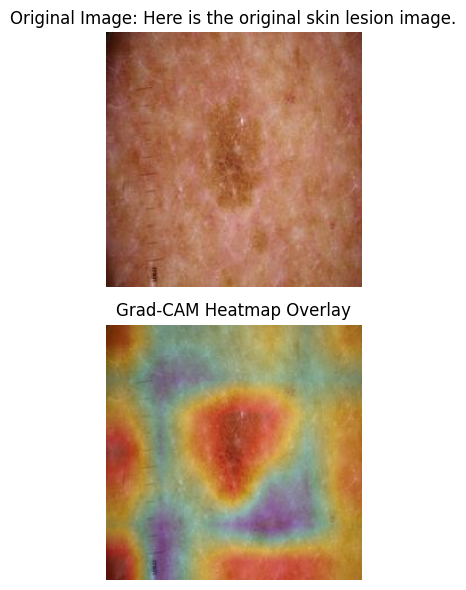

Generating Grad-CAMs:  10%|█         | 1/10 [00:00<00:05,  1.63it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 95.14%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


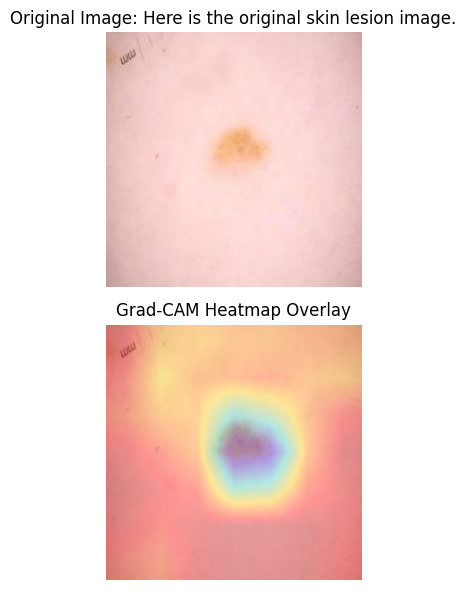

Generating Grad-CAMs:  20%|██        | 2/10 [00:01<00:04,  1.68it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 99.93%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


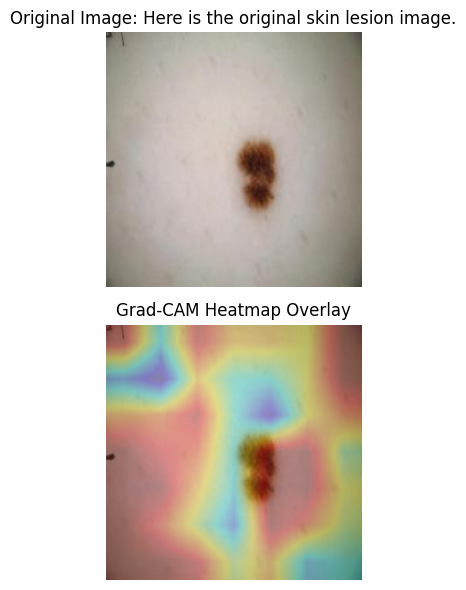

Generating Grad-CAMs:  30%|███       | 3/10 [00:01<00:04,  1.69it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 65.33%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


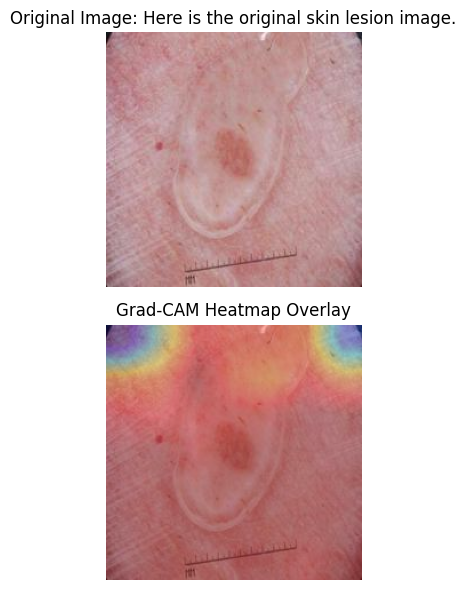

Generating Grad-CAMs:  40%|████      | 4/10 [00:02<00:03,  1.66it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 51.88%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


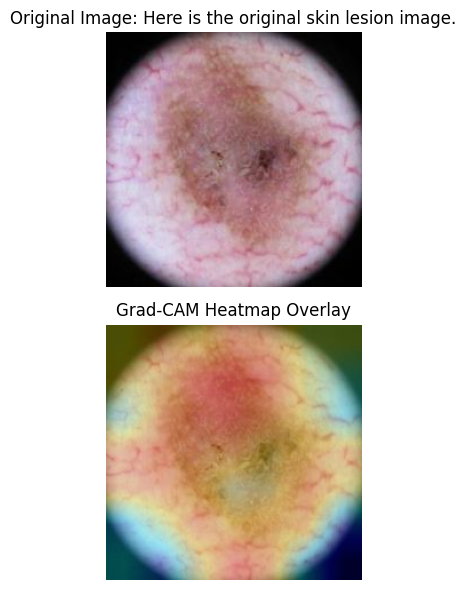

Generating Grad-CAMs:  50%|█████     | 5/10 [00:03<00:03,  1.65it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 100.00%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


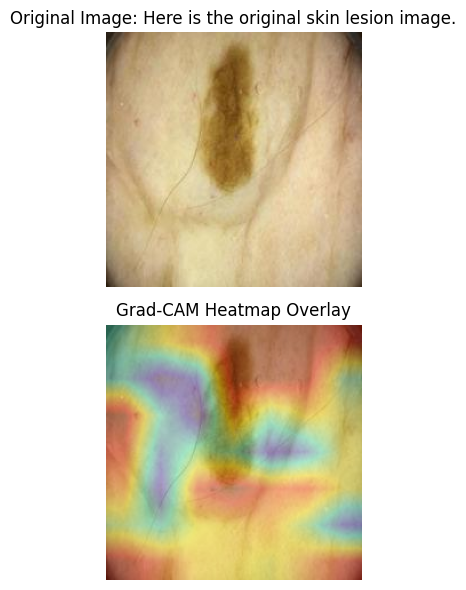

Generating Grad-CAMs:  60%|██████    | 6/10 [00:03<00:02,  1.64it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 75.83%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


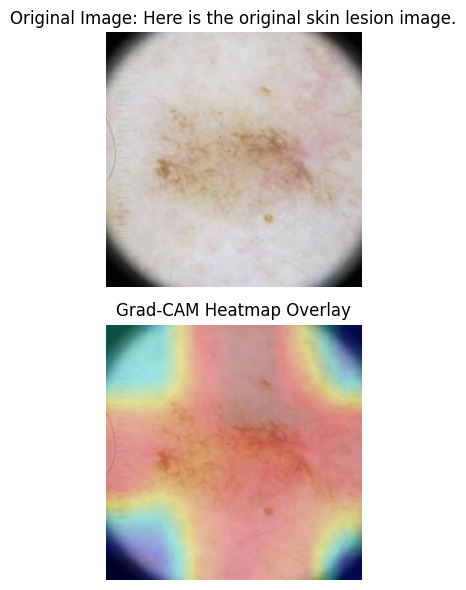

Generating Grad-CAMs:  70%|███████   | 7/10 [00:04<00:01,  1.65it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 99.99%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


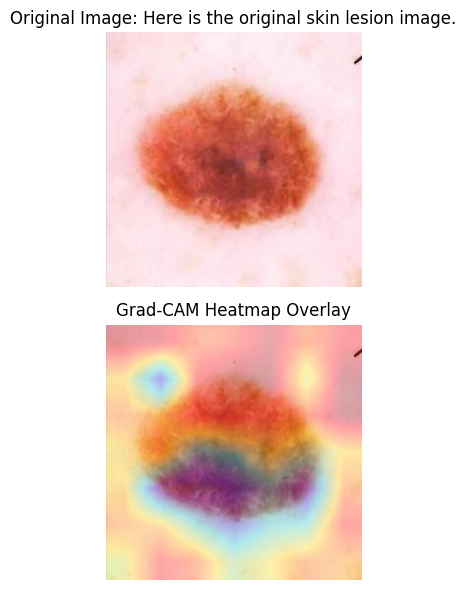

Generating Grad-CAMs:  80%|████████  | 8/10 [00:04<00:01,  1.65it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 84.94%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


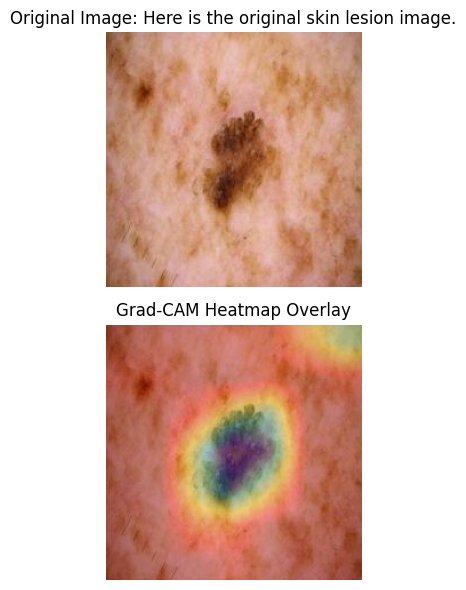

Generating Grad-CAMs:  90%|█████████ | 9/10 [00:05<00:00,  1.64it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 50.75%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


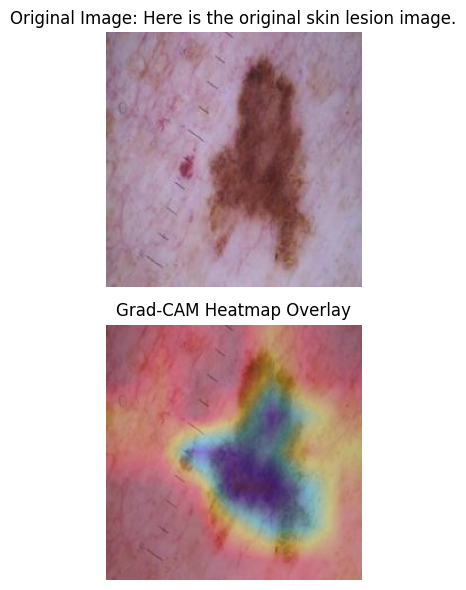

Generating Grad-CAMs: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 77.26%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."

 Grad-CAM explanations generated and displayed successfully.


In [14]:
# Grad-CAM Implementation
print("\n" + "="*50)
print("--- Starting Grad-CAM Explanations ---")
print("="*50 + "\n")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates Grad-CAM heatmap for a given image and model.
    Args:
        img_array: Preprocessed image array (batch of 1: (1, H, W, C)).
        model: Trained Keras model.
        last_conv_layer_name: Name of the last convolutional layer in the base model.
        pred_index: Optional. If specified, computes heatmap for this class.
                    Otherwise, computes for the top predicted class.
    Returns:
        Numpy array representing the heatmap or None if gradient is None.
    """
    input_layer = model.layers[0].input
    resnet_base_model = model.get_layer('resnet50')
    last_conv_layer_output = resnet_base_model.get_layer(last_conv_layer_name).output

    x = last_conv_layer_output
    for layer in model.layers[1:]:
        x = layer(x)
    final_output = x

    grad_model = tf.keras.models.Model(
        inputs=input_layer,
        outputs=[last_conv_layer_output, final_output]
    )

    img_array = tf.cast(img_array, tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])

        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    if grads is None:
        print("Gradient is None. Returning None for heatmap.")
        return None

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())

    heatmap = tf.cast(heatmap, tf.float32)
    return heatmap.numpy()

# Grad-CAM Visualization Loop
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}

test_true_labels = test_generator.classes
test_pred_labels = np.argmax(model.predict(test_generator), axis=1)

# Separate indices for correct and incorrect predictions
correctly_classified_indices = np.where(test_true_labels == test_pred_labels)[0]
misclassified_indices = np.where(test_true_labels != test_pred_labels)[0]

num_samples_to_visualize_gradcam = 10
sample_indices_gradcam = []

# Prioritize misclassified samples for Grad-CAM
num_misclassified_to_pick = min(num_samples_to_visualize_gradcam // 2, len(misclassified_indices))
num_correct_to_pick = min(num_samples_to_visualize_gradcam - num_misclassified_to_pick, len(correctly_classified_indices))

sample_indices_gradcam.extend(random.sample(list(misclassified_indices), num_misclassified_to_pick))
sample_indices_gradcam.extend(random.sample(list(correctly_classified_indices), num_correct_to_pick))
random.shuffle(sample_indices_gradcam)

print(f"Attempting to visualize {len(sample_indices_gradcam)} images with Grad-CAM (prioritizing misclassified).")

last_conv_layer_name = 'conv5_block3_out'

for i in tqdm(sample_indices_gradcam, desc="Generating Grad-CAMs"):
    img_path = test_generator.filepaths[i]
    img_array_preprocessed, img_rgb_resized, img_rgb_original_full_size = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    if img_array_preprocessed is None:
        print(f"Could not read image at {img_path}. Skipping for Grad-CAM.")
        continue

    original_height, original_width = img_rgb_original_full_size.shape[:2]

    # Get model's predicted class and confidence for this image
    predicted_probs = model.predict(img_array_preprocessed)
    predicted_class_idx = np.argmax(predicted_probs[0])
    predicted_class_label = idx_to_class[predicted_class_idx]
    confidence = predicted_probs[0][predicted_class_idx] * 100

    # Generate heatmap for the predicted class
    heatmap = make_gradcam_heatmap(img_array_preprocessed, model, last_conv_layer_name, pred_index=predicted_class_idx)

    if heatmap is not None:
        heatmap_resized = cv2.resize(heatmap, (original_width, original_height))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)


        superimposed_img = cv2.addWeighted(img_rgb_original_full_size, 0.7, heatmap_colored, 0.3, 0)

        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.imshow(img_rgb_original_full_size)
        plt.title("Original Image: Here is the original skin lesion image.")
        plt.axis('off')

        plt.subplot(2, 1, 2)
        plt.imshow(superimposed_img)
        plt.title("Grad-CAM Heatmap Overlay")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f'Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."')
        print(f'Explanation: "The model predicts this lesion as {predicted_class_label} with a confidence of {confidence:.2f}%. '
              f'The red regions represent areas that the model believes to be most indicative of {predicted_class_label.lower()} tissue. '
              f'These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."')
        plt.pause(0.1)
    else:
        print(f"Could not generate Grad-CAM for image at index {i}.")

print("\n Grad-CAM explanations generated and displayed successfully.")




--- Starting Grad-CAM++ Explanations ---

Attempting to visualize Grad-CAM++ for 10 images.


Generating Grad-CAM++s:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Processing image index 1502 for Grad-CAM++...
Grad-CAM++ heatmap generated for image index 1502.


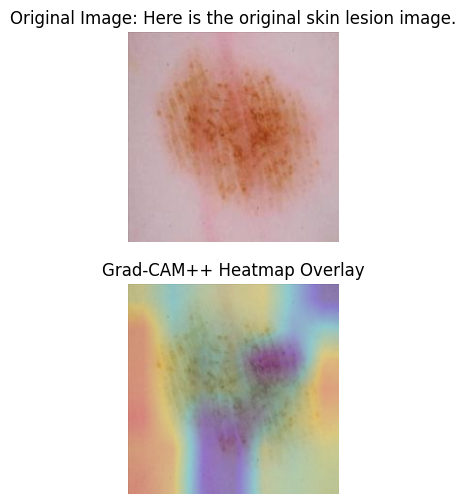

Generating Grad-CAM++s:  10%|█         | 1/10 [00:00<00:08,  1.06it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 66.45%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Processing image index 1724 for Grad-CAM++...
Grad-CAM++ heatmap generated for image index 1724.


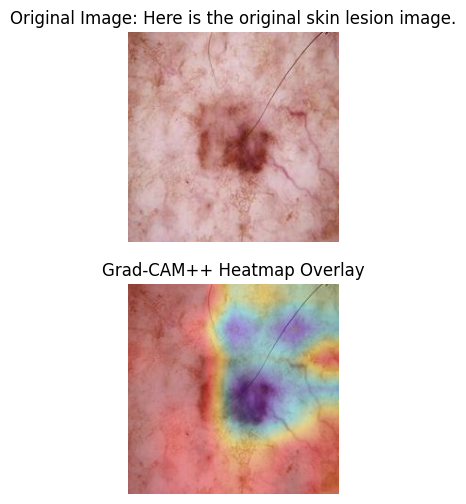

Generating Grad-CAM++s:  20%|██        | 2/10 [00:01<00:07,  1.06it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 96.72%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Processing image index 588 for Grad-CAM++...
Grad-CAM++ heatmap generated for image index 588.


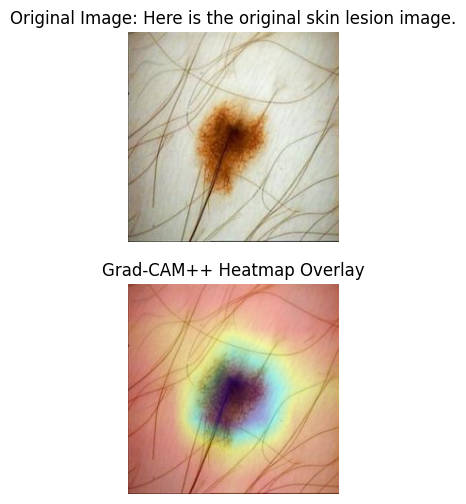

Generating Grad-CAM++s:  30%|███       | 3/10 [00:02<00:06,  1.05it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 91.83%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Processing image index 3 for Grad-CAM++...
Grad-CAM++ heatmap generated for image index 3.


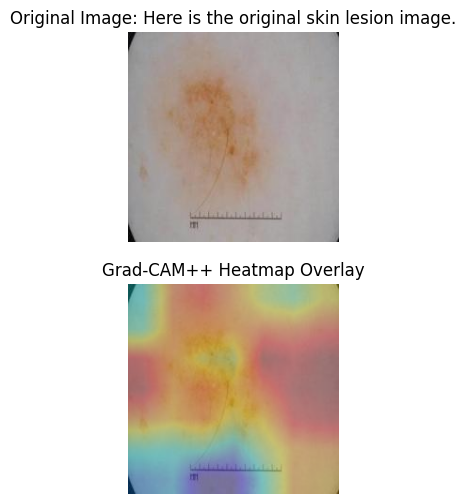

Generating Grad-CAM++s:  40%|████      | 4/10 [00:03<00:05,  1.06it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 53.82%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Processing image index 926 for Grad-CAM++...
Grad-CAM++ heatmap generated for image index 926.


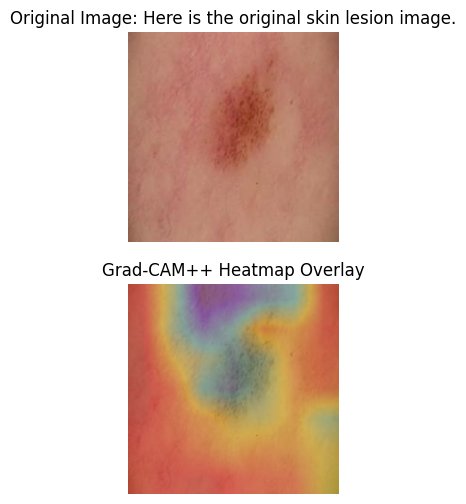

Generating Grad-CAM++s:  50%|█████     | 5/10 [00:04<00:04,  1.06it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 97.24%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Processing image index 1789 for Grad-CAM++...
Grad-CAM++ heatmap generated for image index 1789.


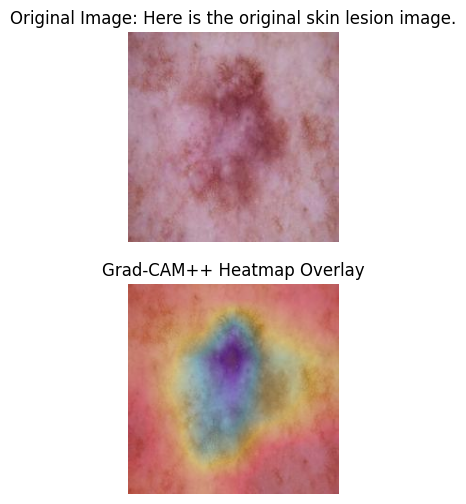

Generating Grad-CAM++s:  60%|██████    | 6/10 [00:05<00:03,  1.06it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 93.70%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Processing image index 527 for Grad-CAM++...
Grad-CAM++ heatmap generated for image index 527.


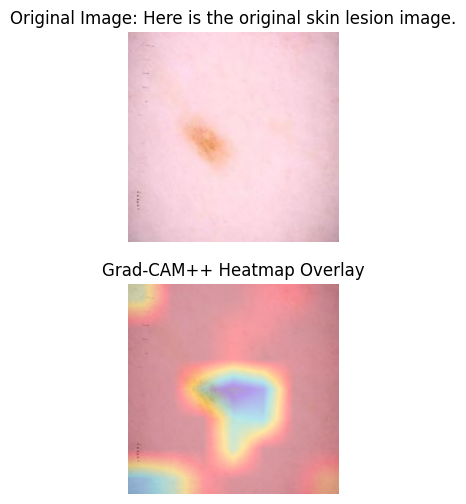

Generating Grad-CAM++s:  70%|███████   | 7/10 [00:06<00:02,  1.06it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 99.98%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Processing image index 400 for Grad-CAM++...
Grad-CAM++ heatmap generated for image index 400.


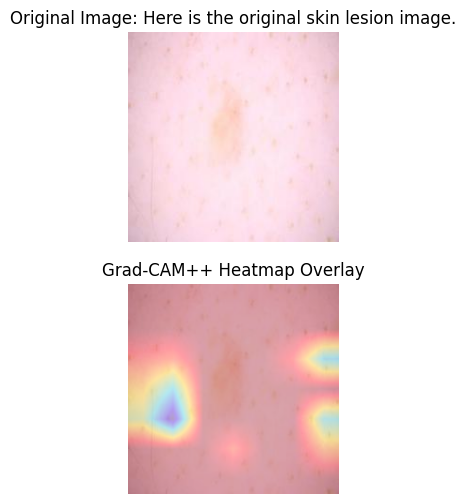

Generating Grad-CAM++s:  80%|████████  | 8/10 [00:07<00:01,  1.07it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 99.99%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Processing image index 1489 for Grad-CAM++...
Grad-CAM++ heatmap generated for image index 1489.


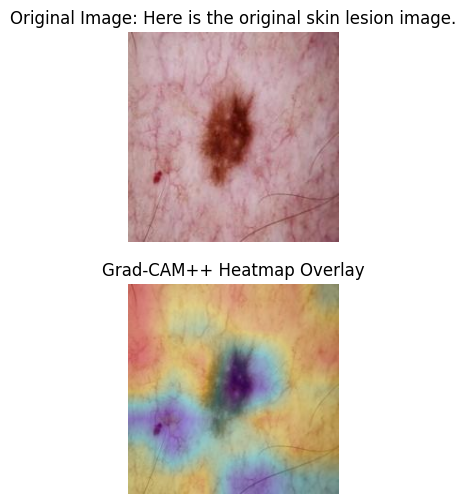

Generating Grad-CAM++s:  90%|█████████ | 9/10 [00:08<00:01,  1.07s/it]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 73.38%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Processing image index 1962 for Grad-CAM++...
Grad-CAM++ heatmap generated for image index 1962.


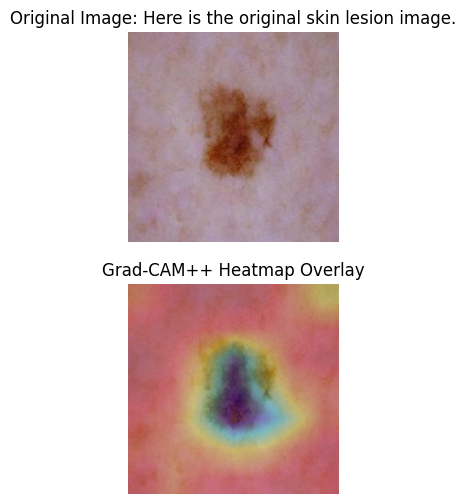

Generating Grad-CAM++s: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 72.81%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."

 Grad-CAM++ explanations generated and displayed successfully.


In [15]:
#  Grad-CAM++ Implementation
print("\n" + "="*50)
print("--- Starting Grad-CAM++ Explanations ---")
print("="*50 + "\n")

def compute_gradcam_plus_plus(model, img_array, last_conv_layer_name, pred_index=None):
    """
    Computes Grad-CAM++ heatmap.

    Args:
        model: Trained Keras model (Sequential model).
        img_array: Preprocessed image array with shape (1, height, width, channels).
        last_conv_layer_name: Name of the target convolutional layer within the base model.
        pred_index: Class index for which Grad-CAM++ is computed. If None, uses the top predicted class.

    Returns:
        heatmap: Grad-CAM++ heatmap as a numpy array.
    """
    # Get the input layer of the sequential model
    input_layer = model.layers[0].input

    resnet_base_model = model.get_layer('resnet50')

    last_conv_layer_output = resnet_base_model.get_layer(last_conv_layer_name).output

    # to get the final output predictions
    x = last_conv_layer_output
    for layer in model.layers[1:]:
        x = layer(x)
    final_output = x

    # Build grad_model using the Functional API
    grad_model = tf.keras.models.Model(
        inputs=input_layer,
        outputs=[last_conv_layer_output, final_output]
    )

    img_array = tf.cast(img_array, tf.float32)

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_outputs, predictions = grad_model(img_array)
                if pred_index is None:
                    pred_index = tf.argmax(predictions[0])
                class_channel = predictions[:, pred_index]

            # First-order gradients
            grads = tape3.gradient(class_channel, conv_outputs)

        # Second-order gradients
        grads2 = tape2.gradient(grads, conv_outputs)

    # Third-order gradients
    grads3 = tape1.gradient(grads2, conv_outputs)

    # Computing alpha coefficients (Grad-CAM++ paper equation)
    # Adding epsilon to denominator to avoid division by zero
    numerator = grads2
    denominator = 2 * grads2 + grads3 * conv_outputs
    denominator = denominator + tf.keras.backend.epsilon()
    alphas = numerator / denominator

    # Applied ReLU to first-order gradients
    weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(0, 1, 2))

    # Compute weighted combination of forward activation maps
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + tf.keras.backend.epsilon()

    return heatmap.numpy()

# Visualization Loop for Grad-CAM++

# Mapping indices to class labels
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Get indices for benign and malignant images in the test set
benign_indices = np.where(test_true_labels == test_generator.class_indices['Benign'])[0]
malignant_indices = np.where(test_true_labels == test_generator.class_indices['Malignant'])[0]

num_samples_to_visualize_pp = 10
sample_indices_pp = []

# Attempt to get a balanced sample
num_benign_pp = min(num_samples_to_visualize_pp // 2, len(benign_indices))
num_malignant_pp = min(num_samples_to_visualize_pp - num_benign_pp, len(malignant_indices))

sample_indices_pp.extend(random.sample(list(benign_indices), num_benign_pp))
sample_indices_pp.extend(random.sample(list(malignant_indices), num_malignant_pp))
# Shuffling selected indices
random.shuffle(sample_indices_pp)

print(f"Attempting to visualize Grad-CAM++ for {len(sample_indices_pp)} images.")

last_conv_layer_name = 'conv5_block3_out'
for i in tqdm(sample_indices_pp, desc="Generating Grad-CAM++s"):
    img_path = test_generator.filepaths[i]
    img_array_preprocessed, img_rgb_resized, img_rgb_original_full_size = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    if img_array_preprocessed is None:
        print(f"Could not read image at {img_path}. Skipping Grad-CAM++ visualization.")
        continue

    original_height, original_width = img_rgb_original_full_size.shape[:2]

    # Get model's predicted class and confidence for this image
    predicted_probs = model.predict(img_array_preprocessed)
    predicted_class_idx = np.argmax(predicted_probs[0])
    predicted_class_label = idx_to_class[predicted_class_idx]
    confidence = predicted_probs[0][predicted_class_idx] * 100

    print(f"Processing image index {i} for Grad-CAM++...")

    # Generate Grad-CAM++ heatmap
    heatmap_pp = compute_gradcam_plus_plus(model, img_array_preprocessed, last_conv_layer_name=last_conv_layer_name, pred_index=predicted_class_idx)

    if heatmap_pp is not None:
        print(f"Grad-CAM++ heatmap generated for image index {i}.")
        heatmap_pp_resized = cv2.resize(heatmap_pp, (original_width, original_height))
        heatmap_pp_colored = cv2.applyColorMap(np.uint8(255 * heatmap_pp_resized), cv2.COLORMAP_JET)

        superimposed_img_pp = cv2.addWeighted(img_rgb_original_full_size, 0.7, heatmap_pp_colored, 0.3, 0) # Adjusted alpha values

        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.imshow(img_rgb_original_full_size)
        plt.title(f"Original Image: Here is the original skin lesion image.")
        plt.axis('off')

        plt.subplot(2, 1, 2)
        plt.imshow(superimposed_img_pp)
        plt.title("Grad-CAM++ Heatmap Overlay")
        plt.axis('off')
        plt.show()
        plt.pause(0.1)
        print(f'Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."')
        print(f'Explanation: "The model predicts this lesion as {predicted_class_label} with a confidence of {confidence:.2f}%. '
              f'The red regions represent areas that the model believes to be most indicative of {predicted_class_label.lower()} tissue. '
              f'These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."')
    else:
        print(f"Could not generate Grad-CAM++ for image at index {i}.")
print("\n Grad-CAM++ explanations generated and displayed successfully.")




--- Starting Vanilla Saliency Explanations ---

Attempting to visualize 5 images with Vanilla Saliency.


Generating Saliency Maps:   0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
------------------------------
Predicted Class: Malignant (Confidence: 84.65%)


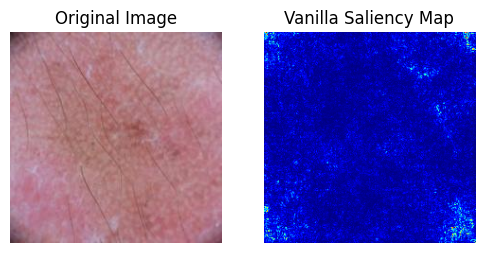

Generating Saliency Maps:  20%|██        | 1/5 [00:00<00:02,  1.75it/s]

Saliency Map: "The light blue areas indicate regions that strongly influence the model's prediction."
Explanation: "The model identified Malignant based on features in the highlighted regions. These pixels were most important in determining the output for the predicted class."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
------------------------------
Predicted Class: Malignant (Confidence: 89.42%)


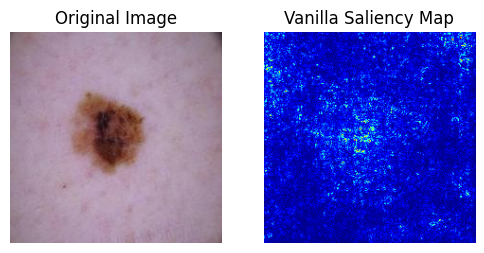

Generating Saliency Maps:  40%|████      | 2/5 [00:01<00:01,  1.76it/s]

Saliency Map: "The light blue areas indicate regions that strongly influence the model's prediction."
Explanation: "The model identified Malignant based on features in the highlighted regions. These pixels were most important in determining the output for the predicted class."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
------------------------------
Predicted Class: Malignant (Confidence: 100.00%)


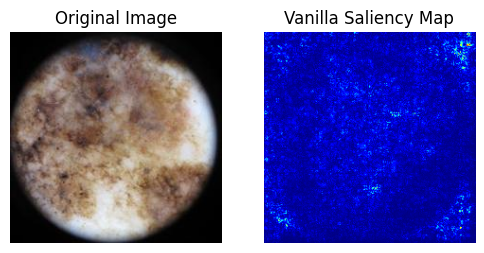

Generating Saliency Maps:  60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

Saliency Map: "The light blue areas indicate regions that strongly influence the model's prediction."
Explanation: "The model identified Malignant based on features in the highlighted regions. These pixels were most important in determining the output for the predicted class."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
------------------------------
Predicted Class: Benign (Confidence: 99.81%)


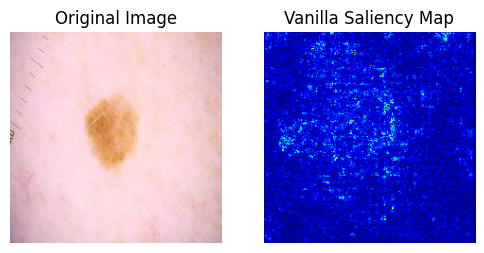

Generating Saliency Maps:  80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Saliency Map: "The light blue areas indicate regions that strongly influence the model's prediction."
Explanation: "The model identified Benign based on features in the highlighted regions. These pixels were most important in determining the output for the predicted class."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
------------------------------
Predicted Class: Benign (Confidence: 99.89%)


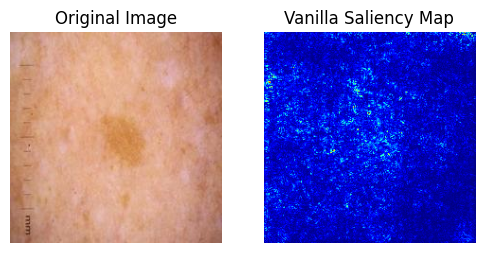

Generating Saliency Maps: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

Saliency Map: "The light blue areas indicate regions that strongly influence the model's prediction."
Explanation: "The model identified Benign based on features in the highlighted regions. These pixels were most important in determining the output for the predicted class."

 Vanilla Saliency explanations generated and displayed successfully.


In [19]:
# Vanilla Saliency
print("\n" + "="*50)
print("--- Starting Vanilla Saliency Explanations ---")
print("="*50 + "\n")

def visualise_saliency_map(model, img_to_explain, class_names, original_img_for_display):
    """
    Visualises the saliency map for a given image and model using the Vanilla
    Saliency method.

    Args:
        model: Trained Keras model.
        img_to_explain (numpy.ndarray): Image to explain (preprocessed for model input, shape (height, width, channels)).
        class_names (list): List of class names.
        original_img_for_display (numpy.ndarray): The original, un-preprocessed RGB image for display.
    """
    # Expand dimensions to create a batch of size 1
    input_img = np.expand_dims(img_to_explain, axis=0)

    # Get the prediction
    prediction = model.predict(input_img)
    predicted_class = np.argmax(prediction[0])
    predicted_class_label = class_names[predicted_class]
    confidence = prediction[0][predicted_class] * 100

    print("-" * 30)
    print(f"Predicted Class: {predicted_class_label} (Confidence: {confidence:.2f}%)")


    # Ensure the input tensor requires gradients
    input_tensor = tf.Variable(input_img, dtype=tf.float32)

    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)

        predictions = model(input_tensor)
        # Get the loss for the predicted class
        loss = predictions[:, predicted_class]

    # Get the gradients of the loss with respect to the input image.
    saliency = tape.gradient(loss, input_tensor)

    # Take the absolute value of the gradients
    saliency = tf.abs(saliency)
    # Reduce to a single channel
    saliency = tf.reduce_max(saliency, axis=-1)
    saliency = (saliency - tf.reduce_min(saliency)) / (
        tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8
    )

    # Convert the saliency map to a NumPy array for visualization
    saliency_map = saliency[0].numpy()

    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img_for_display)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='jet')
    plt.title("Vanilla Saliency Map")
    plt.axis('off')
    plt.show()
    plt.pause(0.1)

    print(f'Saliency Map: "The light blue areas indicate regions that strongly influence the model\'s prediction."')
    print(f'Explanation: "The model identified {predicted_class_label} based on features in the highlighted regions. '
          f'These pixels were most important in determining the output for the predicted class."')

# Get class names from test generator
class_names = list(test_generator.class_indices.keys())

num_saliency_samples = 5
print(f"Attempting to visualize {num_saliency_samples} images with Vanilla Saliency.")

for _ in tqdm(range(num_saliency_samples), desc="Generating Saliency Maps"):
    # Select a random image from the test set
    sample_index_saliency = random.choice(range(len(test_generator.filepaths)))
    img_path_saliency = test_generator.filepaths[sample_index_saliency]

    # Load and preprocess the image using the helper function
    img_array_preprocessed_saliency, img_rgb_resized_saliency, img_rgb_original_full_size = \
        load_and_preprocess_single_image(img_path_saliency, target_size=(IMG_HEIGHT, IMG_WIDTH))

    if img_array_preprocessed_saliency is None:
        print(f"Could not read image at {img_path_saliency}. Skipping Saliency Map.")
    else:

        visualise_saliency_map(model, img_array_preprocessed_saliency[0], class_names, img_rgb_original_full_size)

print("\n Vanilla Saliency explanations generated and displayed successfully.")



--- Starting SmoothGrad Explanations ---

Attempting to visualize 5 images with SmoothGrad.


Generating SmoothGrad Maps:   0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
------------------------------
Predicted Class: Malignant (Confidence: 97.56%)


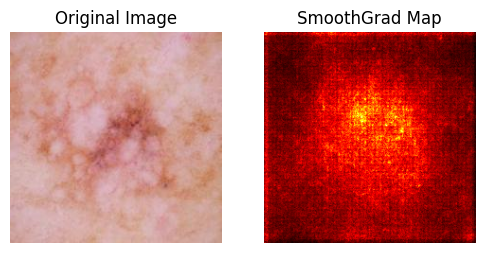

Generating SmoothGrad Maps:  20%|██        | 1/5 [00:02<00:08,  2.12s/it]

SmoothGrad Map: "The red/yellow areas indicate regions that strongly influence the model's prediction (smoothed)."
Explanation: "By averaging gradients over noisy versions of the input, SmoothGrad provides a less noisy and more robust saliency map. The highlighted regions are consistently important for the model's Malignant prediction."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
------------------------------
Predicted Class: Benign (Confidence: 99.98%)


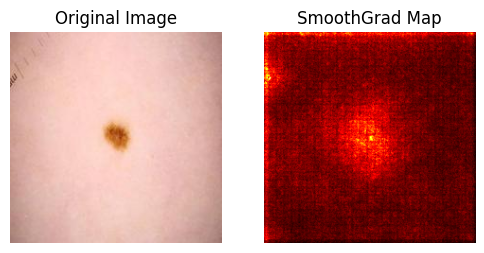

Generating SmoothGrad Maps:  40%|████      | 2/5 [00:03<00:05,  1.96s/it]

SmoothGrad Map: "The red/yellow areas indicate regions that strongly influence the model's prediction (smoothed)."
Explanation: "By averaging gradients over noisy versions of the input, SmoothGrad provides a less noisy and more robust saliency map. The highlighted regions are consistently important for the model's Benign prediction."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
------------------------------
Predicted Class: Malignant (Confidence: 100.00%)


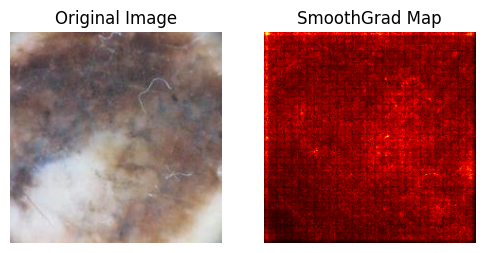

Generating SmoothGrad Maps:  60%|██████    | 3/5 [00:05<00:03,  1.92s/it]

SmoothGrad Map: "The red/yellow areas indicate regions that strongly influence the model's prediction (smoothed)."
Explanation: "By averaging gradients over noisy versions of the input, SmoothGrad provides a less noisy and more robust saliency map. The highlighted regions are consistently important for the model's Malignant prediction."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
------------------------------
Predicted Class: Malignant (Confidence: 99.57%)


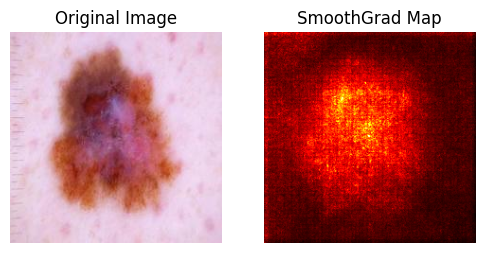

Generating SmoothGrad Maps:  80%|████████  | 4/5 [00:07<00:01,  1.92s/it]

SmoothGrad Map: "The red/yellow areas indicate regions that strongly influence the model's prediction (smoothed)."
Explanation: "By averaging gradients over noisy versions of the input, SmoothGrad provides a less noisy and more robust saliency map. The highlighted regions are consistently important for the model's Malignant prediction."
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
------------------------------
Predicted Class: Benign (Confidence: 99.98%)


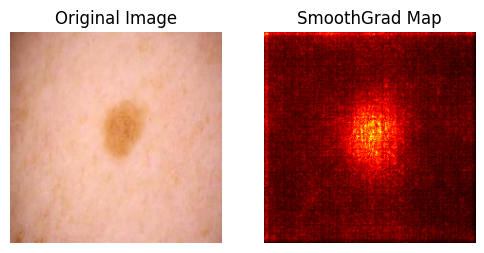

Generating SmoothGrad Maps: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]

SmoothGrad Map: "The red/yellow areas indicate regions that strongly influence the model's prediction (smoothed)."
Explanation: "By averaging gradients over noisy versions of the input, SmoothGrad provides a less noisy and more robust saliency map. The highlighted regions are consistently important for the model's Benign prediction."

 SmoothGrad explanations generated and displayed successfully.


In [20]:
# SmoothGrad Implementation
print("\n" + "="*50)
print("--- Starting SmoothGrad Explanations ---")
print("="*50 + "\n")

def compute_smooth_grad(model, img_to_explain, class_names, original_img_for_display, num_samples=50, noise_level=0.1):
    """
    Computes and visualizes the SmoothGrad saliency map for a given image.

    Args:
        model: Trained Keras model.
        img_to_explain (numpy.ndarray): Image to explain (preprocessed for model input, shape (height, width, channels)).
        class_names (list): List of class names.
        original_img_for_display (numpy.ndarray): The original, un-preprocessed RGB image for display.
        num_samples (int): Number of noisy samples to generate.
        noise_level (float): Standard deviation of the Gaussian noise to add.
    """
    input_img = np.expand_dims(img_to_explain, axis=0)
    prediction = model.predict(input_img)
    predicted_class = np.argmax(prediction[0])
    predicted_class_label = class_names[predicted_class]
    confidence = prediction[0][predicted_class] * 100

    print("-" * 30)
    print(f"Predicted Class: {predicted_class_label} (Confidence: {confidence:.2f}%)")
    noisy_inputs = []
    img_dtype = input_img.dtype
    img_min = np.min(input_img)
    img_max = np.max(input_img)
    img_range = img_max - img_min
    if img_range == 0:
        img_range = 1.0

    for _ in range(num_samples):
        # Generate Gaussian noise with standard deviation scaled by noise_level and image range
        noise = tf.random.normal(shape=tf.shape(input_img), mean=0.0, stddev=noise_level * img_range, dtype=tf.float32)
        noisy_input = tf.cast(input_img, tf.float32) + noise
        noisy_inputs.append(noisy_input)

    # Concatenate noisy inputs into a single tensor
    noisy_inputs = tf.concat(noisy_inputs, axis=0)

    # Use GradientTape to record operations
    with tf.GradientTape() as tape:
        tape.watch(noisy_inputs)
        predictions = model(noisy_inputs)
        loss = predictions[:, predicted_class]
    saliency_maps = tape.gradient(loss, noisy_inputs)

    # Take the absolute value of the gradients and average across samples
    saliency_maps = tf.abs(saliency_maps)
    smooth_grad = tf.reduce_mean(saliency_maps, axis=0)
    smooth_grad = tf.reduce_max(smooth_grad, axis=-1)
    smooth_grad = (smooth_grad - tf.reduce_min(smooth_grad)) / (
        tf.reduce_max(smooth_grad) - tf.reduce_min(smooth_grad) + 1e-8
    )

    # Convert the SmoothGrad map to a NumPy array for visualization
    smooth_grad_map = smooth_grad.numpy()


    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img_for_display)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(smooth_grad_map, cmap='hot')
    plt.title("SmoothGrad Map")
    plt.axis('off')
    plt.show()
    plt.pause(0.1)

    print(f'SmoothGrad Map: "The red/yellow areas indicate regions that strongly influence the model\'s prediction (smoothed)."')
    print(f'Explanation: "By averaging gradients over noisy versions of the input, SmoothGrad provides a less noisy and more robust saliency map. '
          f'The highlighted regions are consistently important for the model\'s {predicted_class_label} prediction."')

# --- Code to load and visualise a sample image with SmoothGrad ---

# Get class names from test generator
class_names = list(test_generator.class_indices.keys())

num_smoothgrad_samples = 5
print(f"Attempting to visualize {num_smoothgrad_samples} images with SmoothGrad.")

for _ in tqdm(range(num_smoothgrad_samples), desc="Generating SmoothGrad Maps"):
    # Select a random image from the test set
    sample_index_smoothgrad = random.choice(range(len(test_generator.filepaths)))
    img_path_smoothgrad = test_generator.filepaths[sample_index_smoothgrad]

    # Load and preprocess the image using the helper function
    img_array_preprocessed_smoothgrad, img_rgb_resized_smoothgrad, img_rgb_original_full_size = \
        load_and_preprocess_single_image(img_path_smoothgrad, target_size=(IMG_HEIGHT, IMG_WIDTH))

    if img_array_preprocessed_smoothgrad is None:
        print(f"Could not read image at {img_path_smoothgrad}. Cannot generate SmoothGrad Map.")
    else:
        # Compute and visualise the SmoothGrad map
        # Pass the image array (remove batch dimension for the function input) and original image for display
        compute_smooth_grad(model, img_array_preprocessed_smoothgrad[0], class_names, img_rgb_original_full_size)

print("\n SmoothGrad explanations generated and displayed successfully.")



In [21]:
# Get the ResNet50 base model layer from the trained model.
resnet_base_model = model.get_layer('resnet50')

# Create a new Keras Model that takes the base model's input and outputs
x = resnet_base_model.output
global_average_pooling_output = model.layers[1](x)

feature_extraction_model = tf.keras.models.Model(
    inputs=resnet_base_model.input,
    outputs=global_average_pooling_output
)
# 3. Use the created feature extraction model to predict features for all images.
print("Extracting features from training images...")
train_features = feature_extraction_model.predict(train_generator)
print("Extracting features from test images...")
test_features = feature_extraction_model.predict(test_generator)

# Retrieve the true labels for the training and test sets.
train_labels = train_generator.classes
test_labels = test_generator.classes

print("\nFeature extraction complete.")
print(f"Training features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")


print("Verifying shapes and data types for XGBoost input:")
print(f"train_features shape: {train_features.shape}, dtype: {train_features.dtype}")
print(f"test_features shape: {test_features.shape}, dtype: {test_features.dtype}")
print(f"train_labels shape: {train_labels.shape}, dtype: {train_labels.dtype}")
print(f"test_labels shape: {test_labels.shape}, dtype: {test_labels.dtype}")


Extracting features from training images...
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 278ms/step
Extracting features from test images...
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step

Feature extraction complete.
Training features shape: (9504, 2048)
Test features shape: (2000, 2048)
Training labels shape: (9504,)
Test labels shape: (2000,)
Verifying shapes and data types for XGBoost input:
train_features shape: (9504, 2048), dtype: float32
test_features shape: (2000, 2048), dtype: float32
train_labels shape: (9504,), dtype: int32
test_labels shape: (2000,), dtype: int32


In [22]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 11.7 MB/s eta 0:00:00


In [23]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False
)
print("Training the XGBoost model...")
xgb_model.fit(train_features, train_labels)
print("XGBoost model successfully trained.")

# Define X_test and y_true_test_set for the SHAP explainer
X_test = test_features
y_true_test_set = test_labels


Training the XGBoost model...
XGBoost model successfully trained.



--- Starting SHAP Explanations (Using KernelExplainer) ---

 SHAP explanations generation function defined using KernelExplainer.

--- Initiating SHAP explanation display with KernelExplainer ---

--- Starting SHAP Explanation (KernelExplainer Mode) for 5 instances ---
Selected 5 test instances for SHAP (2 Benign, 3 Malignant).
Selecting 100 background samples from training data...
Initializing SHAP KernelExplainer...
Calculating SHAP values for 5 test instances using KernelExplainer... (this may take a while)


  0%|          | 0/5 [00:00<?, ?it/s]

Generating SHAP plots...


Displaying SHAP plots:   0%|          | 0/5 [00:00<?, ?it/s]


--- Instance 1/5 ---
True Class: Benign, Predicted Class: Benign


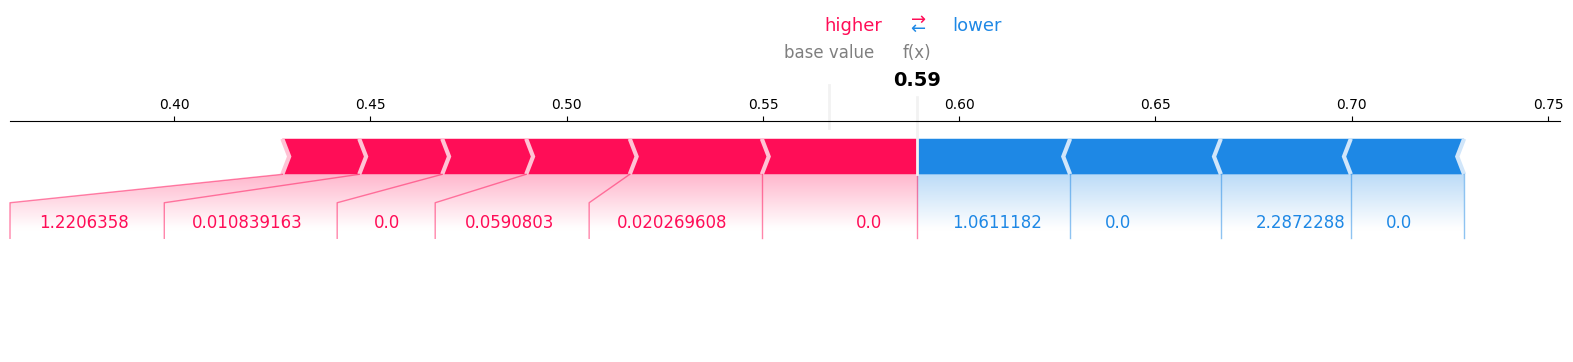

Displaying SHAP plots:  20%|██        | 1/5 [00:00<00:01,  3.51it/s]


--- Instance 2/5 ---
True Class: Malignant, Predicted Class: Benign


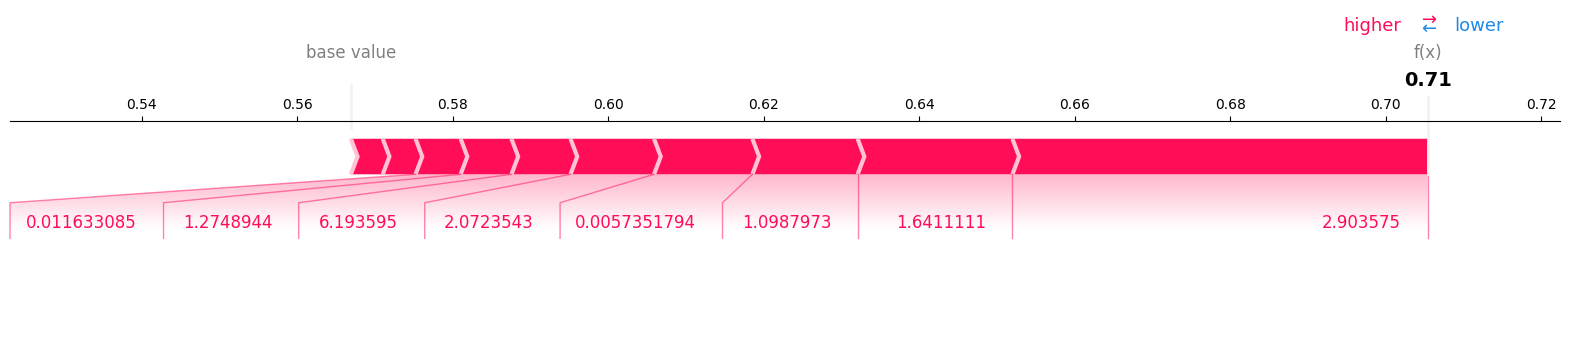

Displaying SHAP plots:  40%|████      | 2/5 [00:00<00:00,  4.23it/s]


--- Instance 3/5 ---
True Class: Malignant, Predicted Class: Benign


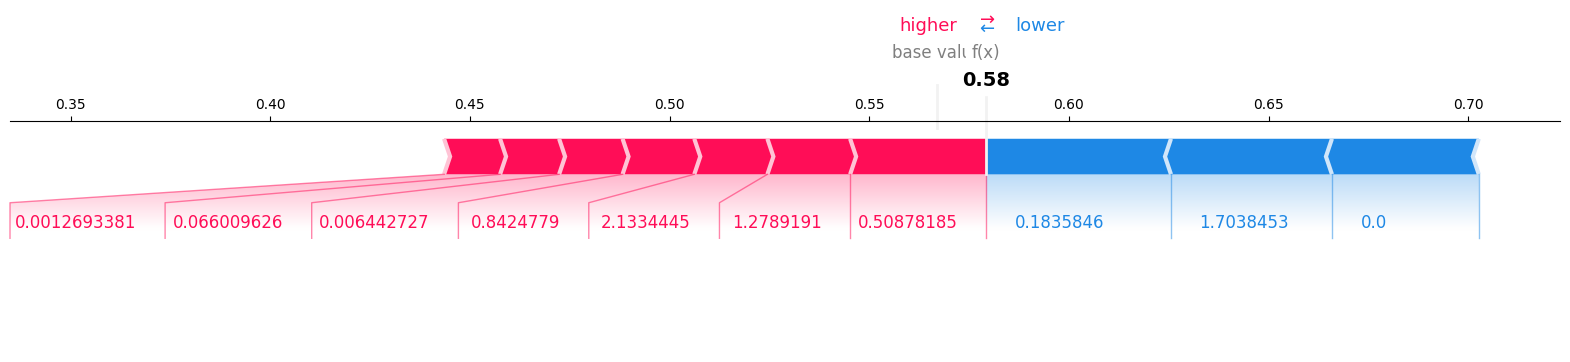

Displaying SHAP plots:  60%|██████    | 3/5 [00:00<00:00,  3.80it/s]


--- Instance 4/5 ---
True Class: Benign, Predicted Class: Malignant


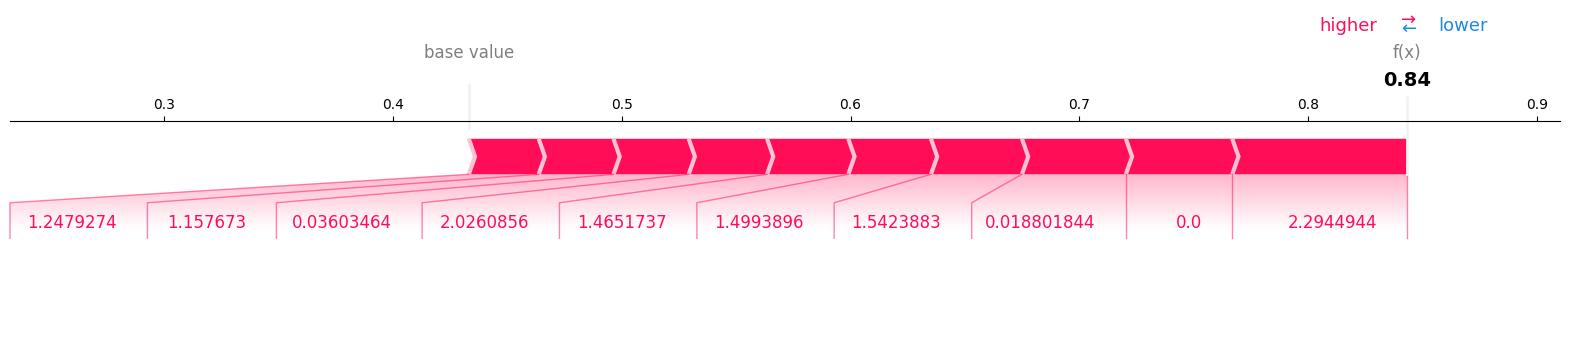

Displaying SHAP plots:  80%|████████  | 4/5 [00:01<00:00,  3.95it/s]


--- Instance 5/5 ---
True Class: Malignant, Predicted Class: Benign


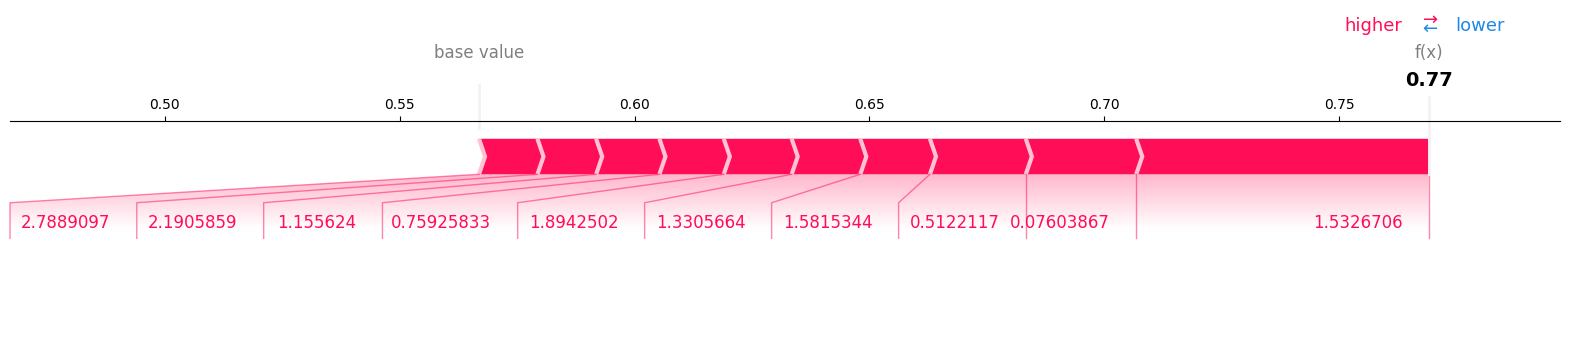

Displaying SHAP plots: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


Generating SHAP Summary Plot for global feature importance across test instances...

--- Script finished ---


In [41]:
# SHAP Explanation Code Integration (Using KernelExplainer)

import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

print("\n" + "="*50)
print("--- Starting SHAP Explanations (Using KernelExplainer) ---")
print("="*50 + "\n")

def explain_with_shap_kernel(model, X_train, X_test, y_true_test_set: np.ndarray, num_test_total: int = 5, background_samples=100):
    """
    Generates and displays SHAP explanations for test data using a trained model
    and shap.KernelExplainer.
    It attempts to select a balanced set of test data for explanation.

    Args:
        model: Trained model (e.g., XGBoost model).
        X_train (np.ndarray or pd.DataFrame): Training data for background dataset.
        X_test (np.ndarray or pd.DataFrame): Test data for SHAP explanation.
        y_true_test_set (np.ndarray): The true labels for the test set.
        num_test_total (int): Total number of test instances to explain (attempting a mix of classes).
        background_samples (int): Number of samples from training data to use for background.
    """
    print(f"\n--- Starting SHAP Explanation (KernelExplainer Mode) for {num_test_total} instances ---")

    selected_indices = []
    benign_test_indices = np.where(y_true_test_set == 0)[0]
    malignant_test_indices = np.where(y_true_test_set == 1)[0]

    num_benign_to_pick = min(num_test_total // 2, len(benign_test_indices))
    num_malignant_to_pick = min(num_test_total - num_benign_to_pick, len(malignant_test_indices))

    selected_indices.extend(random.sample(list(benign_test_indices), num_benign_to_pick))
    selected_indices.extend(random.sample(list(malignant_test_indices), num_malignant_to_pick))
    random.shuffle(selected_indices)

    if not selected_indices:
        print("Error: No suitable test instances (Benign/Malignant) found for SHAP explanation. Exiting.")
        return

    print(f"Selected {len(selected_indices)} test instances for SHAP ({num_benign_to_pick} Benign, {num_malignant_to_pick} Malignant).")

    X_test_for_shap = X_test[selected_indices]
    y_true_for_shap = y_true_test_set[selected_indices]

    # background dataset for KernelExplainer
    print(f"Selecting {background_samples} background samples from training data...")
    if X_train.shape[0] < background_samples:
        print(f"Warning: Not enough training samples ({X_train.shape[0]}) for {background_samples} background samples. Using all training samples.")
        background_data = X_train
    else:
        background_indices = random.sample(range(X_train.shape[0]), background_samples)
        background_data = X_train[background_indices]
    print("Initializing SHAP KernelExplainer...")
    explainer = shap.KernelExplainer(model.predict_proba, background_data)

    # Compute SHAP values for test instances
    print(f"Calculating SHAP values for {X_test_for_shap.shape[0]} test instances using KernelExplainer... (this may take a while)")
    shap_values_explanation = explainer(X_test_for_shap)
    print("Generating SHAP plots...")

    # Get class names from test generator
    try:
        class_names = list(test_generator.class_indices.keys())
    except NameError:
        print("Warning: test_generator not found. Using default class names 'Class 0', 'Class 1'.")
        class_names = ["Class 0", "Class 1"]

    for i in tqdm(range(X_test_for_shap.shape[0]), desc="Displaying SHAP plots"):
        predicted_probs = model.predict_proba(X_test_for_shap[i].reshape(1, -1))
        predicted_class_idx = np.argmax(predicted_probs[0])

        true_class_idx = y_true_for_shap[i]

        print(f"\n--- Instance {i+1}/{X_test_for_shap.shape[0]} ---")
        print(f"True Class: {class_names[true_class_idx]}, Predicted Class: {class_names[predicted_class_idx]}")
        shap.plots.force(shap_values_explanation[i, :, predicted_class_idx],matplotlib=True)

    print("\nGenerating SHAP Summary Plot for global feature importance across test instances...")

    try:
        # Generate summary plot for the 'Malignant' class
        class_index_for_summary = 1
        shap.summary_plot(shap_values_explanation[:,:,class_index_for_summary], feature_names=class_names)
    except Exception as e:
        print(f"An error occurred while generating the SHAP summary plot: {e}")


print(" SHAP explanations generation function defined using KernelExplainer.")

# Call SHAP explanation function with KernelExplainer
try:
    if 'xgb_model' in locals() and 'train_features' in locals() and 'test_features' in locals() and 'test_labels' in locals():
         print("\n--- Initiating SHAP explanation display with KernelExplainer ---")
         explain_with_shap_kernel(xgb_model, train_features, test_features, test_labels, num_test_total=5, background_samples=100)
    else:
        print("\nError: Required variables (xgb_model, train_features, test_features, test_labels) for KernelExplainer SHAP not found.")
        print("Please ensure your XGBoost model is trained and features/labels are prepared.")

except Exception as e:
    print(f"An error occurred during SHAP explanation display with KernelExplainer: {e}")

print("\n--- Script finished ---")



--- Starting SHAP Explanations with Partition Explainer ---


--- Initiating SHAP explanation display with Partition Explainer ---

--- Starting SHAP Explanation with Partition Explainer for 10 images ---
Selected 10 test images for SHAP (5 Benign, 5 Malignant).


Preparing test images for SHAP: 100%|██████████| 10/10 [00:00<00:00, 4867.48it/s]

Preprocessed test images shape for SHAP: (10, 224, 224, 3)
Initializing SHAP Partition Explainer...


Calculating SHAP values for 10 test images... (this may take a while)


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 3/10 [00:56<01:45, 15.07s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 4/10 [01:24<02:02, 20.35s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 5/10 [01:53<01:58, 23.80s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 6/10 [02:21<01:40, 25.14s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 7/10 [02:50<01:19, 26.44s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 8/10 [03:21<00:55, 27.81s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 9/10 [03:52<00:28, 28.81s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 10/10 [04:19<00:00, 28.45s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [04:47, 28.77s/it]

Generating SHAP plots (manual)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step



Displaying SHAP plots:   0%|          | 0/10 [00:00<?, ?it/s]

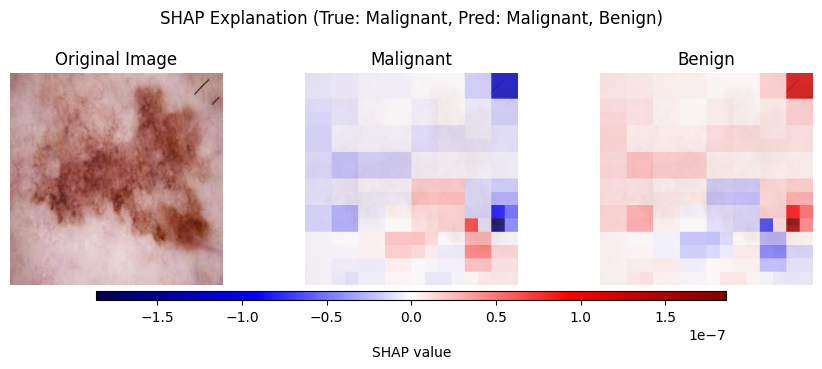

Displaying SHAP plots:  10%|█         | 1/10 [00:00<00:01,  5.66it/s]

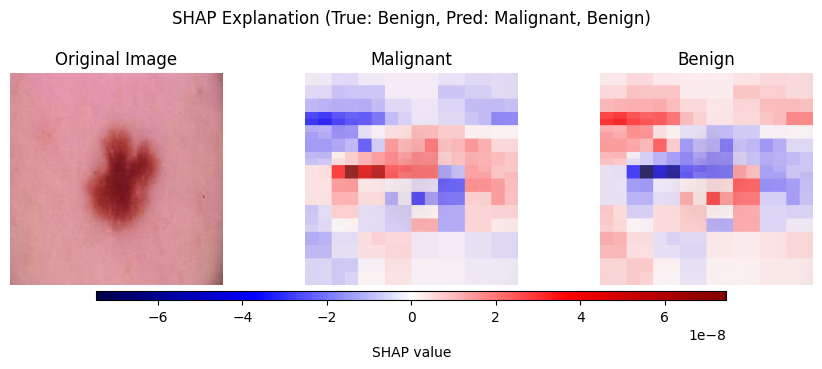

Displaying SHAP plots:  20%|██        | 2/10 [00:00<00:04,  1.98it/s]

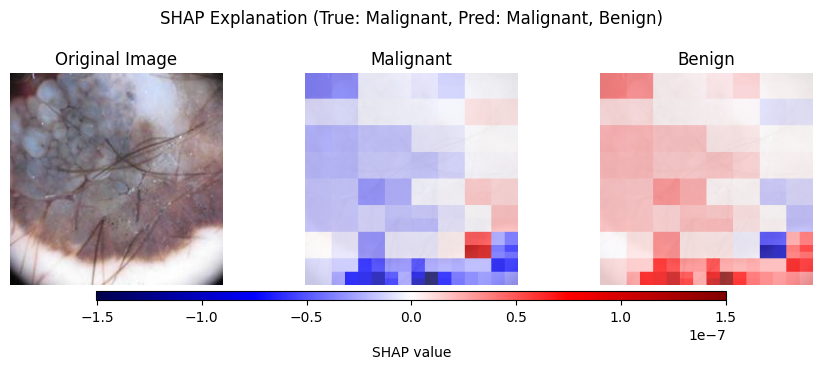

Displaying SHAP plots:  30%|███       | 3/10 [00:01<00:02,  2.80it/s]

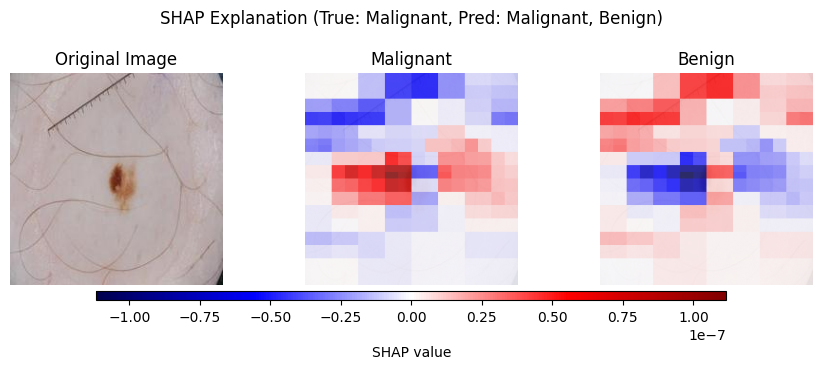

Displaying SHAP plots:  40%|████      | 4/10 [00:01<00:01,  3.54it/s]

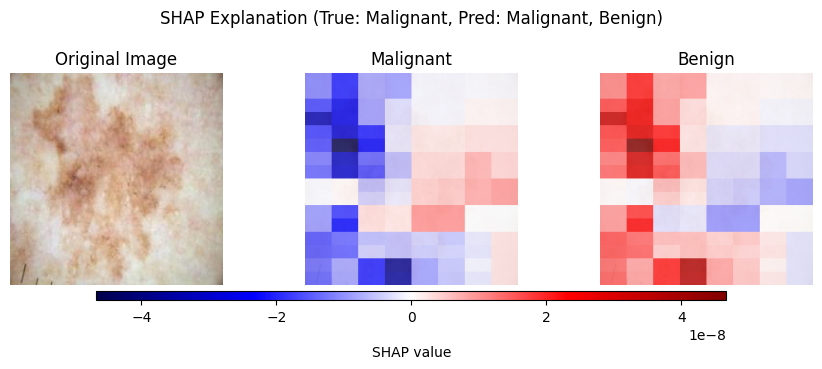

Displaying SHAP plots:  50%|█████     | 5/10 [00:01<00:01,  4.10it/s]

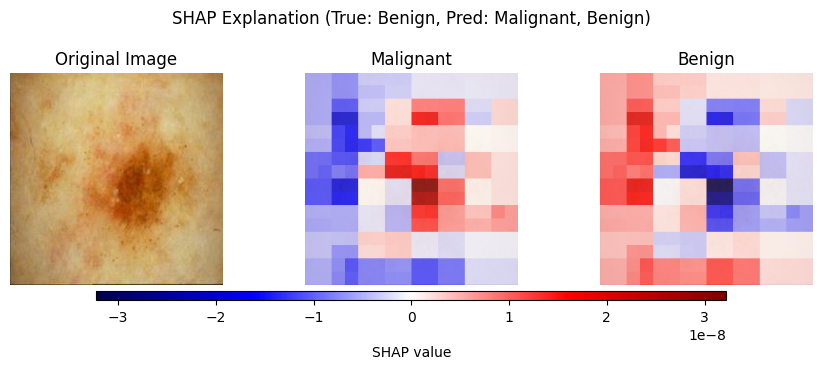

Displaying SHAP plots:  60%|██████    | 6/10 [00:01<00:00,  4.52it/s]

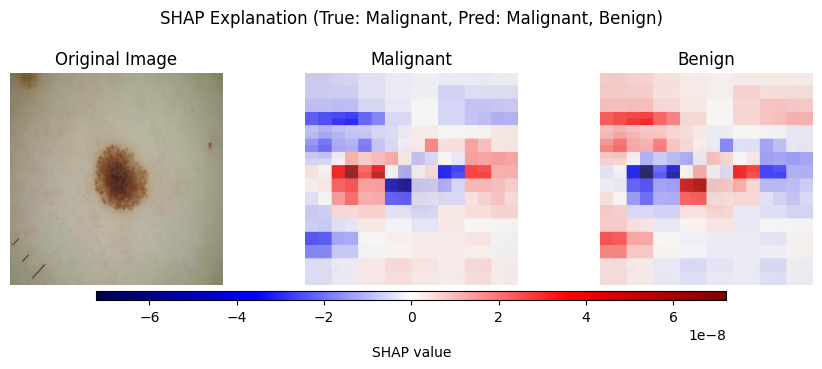

Displaying SHAP plots:  70%|███████   | 7/10 [00:01<00:00,  5.00it/s]

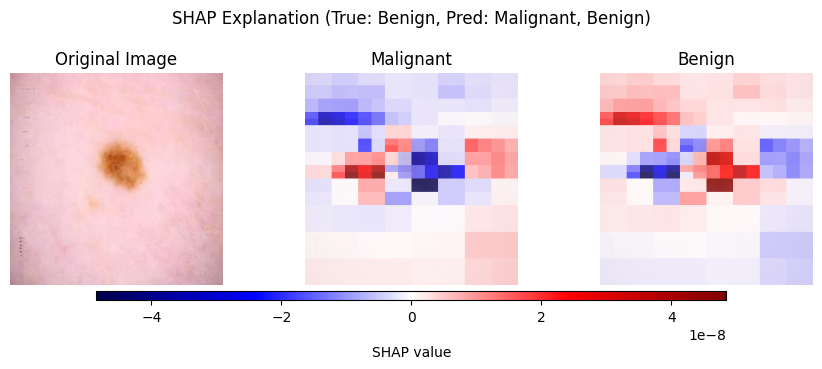

Displaying SHAP plots:  80%|████████  | 8/10 [00:01<00:00,  5.35it/s]

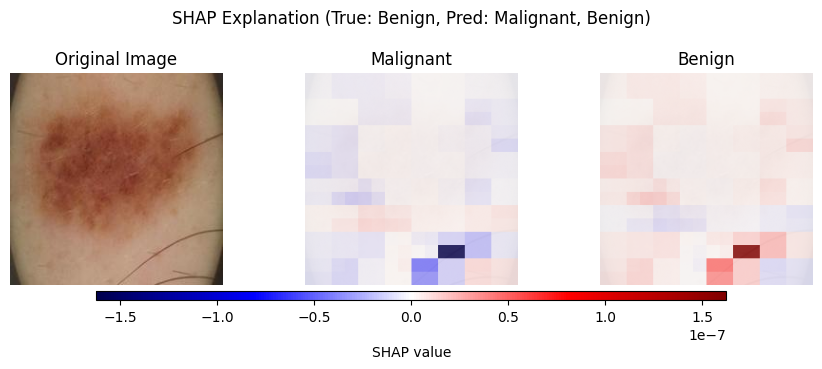

Displaying SHAP plots:  90%|█████████ | 9/10 [00:02<00:00,  5.53it/s]

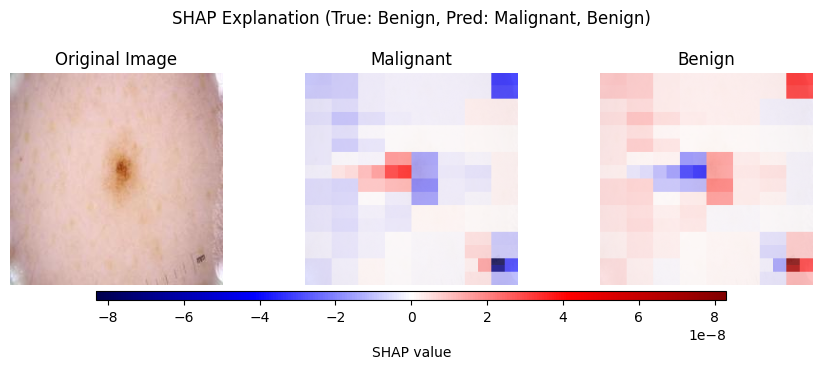

Displaying SHAP plots: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

 SHAP explanations generated and displayed successfully.

--- Script finished ---


In [44]:

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
# SHAP (Partition Explainer)
print("\n" + "="*50)
print("--- Starting SHAP Explanations with Partition Explainer ---")
print("="*50 + "\n")

def preprocess_input(x):
    return (x / 127.5) - 1.0

def explain_with_partition_explainer(model: tf.keras.Model, test_generator, y_true_test_set: np.ndarray, num_test_total: int = 10, num_classes_to_explain: int = 2):
    """
    Generates and displays SHAP explanations for test images using shap.PartitionExplainer.

    Args:
        model: Trained Keras model.
        test_generator: Data generator containing test images.
        y_true_test_set (np.ndarray): The true labels for the test set.
        num_test_total: Total number of test images to explain.
        num_classes_to_explain: The number of top predicted classes to visualize.
    """
    print(f"\n--- Starting SHAP Explanation with Partition Explainer for {num_test_total} images ---")
    test_images_for_shap = []
    original_images_for_display = []
    true_labels_for_shap_indices = []
    selected_test_generator_indices = []

    class_names_map = {v: k for k, v in test_generator.class_indices.items()}
    benign_class_idx = test_generator.class_indices.get('Benign', 0)
    malignant_class_idx = test_generator.class_indices.get('Malignant', 1)

    benign_test_indices = np.where(y_true_test_set == benign_class_idx)[0]
    malignant_test_indices = np.where(y_true_test_set == malignant_class_idx)[0]

    num_benign_to_pick = min(num_test_total // 2, len(benign_test_indices))
    num_malignant_to_pick = min(num_test_total - num_benign_to_pick, len(malignant_test_indices))

    selected_indices = []
    selected_indices.extend(random.sample(list(benign_test_indices), num_benign_to_pick))
    selected_indices.extend(random.sample(list(malignant_test_indices), num_malignant_to_pick))
    random.shuffle(selected_indices)

    if not selected_indices:
        print("Error: No suitable test images (Benign/Malignant) found for SHAP explanation. Exiting.")
        return

    print(f"Selected {len(selected_indices)} test images for SHAP ({num_benign_to_pick} Benign, {num_malignant_to_pick} Malignant).")

    for idx in tqdm(selected_indices, desc="Preparing test images for SHAP"):
        img_path = test_generator.filepaths[idx]
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read image at {img_path}. Skipping for SHAP.")
            continue

        img_rgb_resized = cv2.cvtColor(cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)), cv2.COLOR_BGR2RGB)
        original_images_for_display.append(img_rgb_resized)
        test_images_for_shap.append(img_rgb_resized)
        true_labels_for_shap_indices.append(y_true_test_set[idx])
        selected_test_generator_indices.append(idx)

    test_images_for_shap = np.array(test_images_for_shap)
    original_images_for_display = np.array(original_images_for_display)
    true_labels_for_shap_indices = np.array(true_labels_for_shap_indices)

    if test_images_for_shap.shape[0] == 0:
        print("Error: No preprocessed test images collected for SHAP explanation. Exiting.")
        return
    print(f"Preprocessed test images shape for SHAP: {test_images_for_shap.shape}")

    # model wrapper function for the explainer
    def model_wrapper(x):
        tmp = x.copy()
        tmp = preprocess_input(tmp)
        return model(tmp)
    print("Initializing SHAP Partition Explainer...")
    masker = shap.maskers.Image(mask_value="inpaint_telea", shape=test_images_for_shap[0].shape)

    explainer = shap.Explainer(
        model_wrapper,
        masker,
        output_names=list(test_generator.class_indices.keys())
    )

    # Compute SHAP values for test images
    print(f"Calculating SHAP values for {test_images_for_shap.shape[0]} test images... (this may take a while)")
    shap_values = explainer(
        test_images_for_shap,
        max_evals=1000,
        batch_size=50,
        outputs=shap.Explanation.argsort.flip[:num_classes_to_explain]
    )
    print("Generating SHAP plots (manual)...")

    predictions_for_shap_images = model.predict(preprocess_input(test_images_for_shap))

    # Get the top predicted classes for each image
    top_predicted_indices = np.argsort(predictions_for_shap_images, axis=1)[:, ::-1][:, :num_classes_to_explain]
    for i in tqdm(range(len(test_images_for_shap)), desc="Displaying SHAP plots"):
        original_img_display = original_images_for_display[i]

        fig, axes = plt.subplots(1, 1 + num_classes_to_explain, figsize=(3 * (1 + num_classes_to_explain), 3))
        predicted_classes = [class_names_map.get(idx, "Unknown") for idx in top_predicted_indices[i]]
        true_class_name = class_names_map.get(true_labels_for_shap_indices[i], "Unknown")
        plt.suptitle(
            f"SHAP Explanation (True: {true_class_name}, Pred: {', '.join(predicted_classes)})",
            y=1.02,
            fontsize=12
        )

        # The values are now stored in a single numpy array with the last dimension for classes
        all_heatmap_values = [np.mean(shap_values.values[i, :, :, :, j], axis=-1) for j in range(num_classes_to_explain)]
        global_vmax = np.max([np.max(np.abs(h)) for h in all_heatmap_values])
        global_vmin = -global_vmax

        # Plot 1: Original Image
        axes[0].imshow(original_img_display)
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        # Plot 2 onwards: SHAP heatmaps for each of the top classes
        for j in range(num_classes_to_explain):
            current_shap_values_for_class = shap_values.values[i, :, :, :, j]
            class_name = class_names_map.get(top_predicted_indices[i][j], "Unknown")
            heatmap = np.mean(current_shap_values_for_class, axis=-1)

            # Plot the heatmap
            axes[j+1].imshow(original_img_display, alpha=0.5)
            axes[j+1].imshow(heatmap, cmap='seismic', vmin=global_vmin, vmax=global_vmax, alpha=0.8)
            axes[j+1].set_title(class_name)
            axes[j+1].axis('off')

        # single color bar for all heatmaps

        cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
        norm = Normalize(vmin=global_vmin, vmax=global_vmax)
        sm = ScalarMappable(cmap='seismic', norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('SHAP value', labelpad=15)

        plt.tight_layout(rect=[0, 0.05, 1, 1])
        plt.show()

    print(" SHAP explanations generated and displayed successfully.")

try:
    print("\n--- Initiating SHAP explanation display with Partition Explainer ---")
    explain_with_partition_explainer(model, test_generator, y_true, num_test_total=10, num_classes_to_explain=2)
except Exception as e:
    print(f"An error occurred during SHAP explanation display: {e}")

print("\n--- Script finished ---")